In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.gridspec as gridspec

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,269,118,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,257,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,280,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,257,107,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [6]:
train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 36): [1051], (0, 21, 52): [1612], (0, 21, 54): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

C:\Users\Kalea\AppData\Local\Temp\ipykernel_13616\635274658.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [7]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3270
klasifikasi_perkara_encoded
0    1378
2    1250
3     287
4     193
1     162
Name: count, dtype: int64


In [8]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1053
klasifikasi_perkara_encoded
0    490
2    439
4     51
3     50
1     23
Name: count, dtype: int64


## Model

### Model Preprocessing

In [9]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

In [10]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [11]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\(\)]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopword Removal

In [12]:
stopword_factory = StopWordRemoverFactory()
stop_words = set(stopword_factory.get_stop_words())

def remove_stopwords(text, stop_words):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))
test_df['stopword_removal'] = test_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))

### Tokenizer

In [13]:
model_scenario_name = "BiLSTM_12"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [14]:
# Tokenisasi
train_sequences = tokenizer.texts_to_sequences(train_df['stopword_removal'])
test_sequences = tokenizer.texts_to_sequences(test_df['stopword_removal'])

In [15]:
vocab_size = len(tokenizer.word_index) + 1  # 4 + 1 = 5
print("Vocabulary size:", vocab_size)

Vocabulary size: 18318


In [16]:
# Padding
# max_len = max(len(seq) for seq in train_sequences)
max_len = 1024
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [17]:
print(max_len)

1024


### Numerical Features

In [18]:
# TANPA LOG TRANSFORM (gunakan salah satu)

train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)

## Integrated Gradients

In [21]:
# Buat model embedding
input_text_new = tf.keras.Input(shape=(1024,), dtype=tf.int32, name='text_input_new')
embedding_layer = loaded_model.get_layer('embedding')
embedding_output = embedding_layer(input_text_new)
embedding_model = tf.keras.Model(inputs=input_text_new, outputs=embedding_output)

# Buat input baru: embedding dan numeric
input_embed = tf.keras.Input(shape=(1024, 256), name='embedding_input')
input_num = tf.keras.Input(shape=(5,), name='numeric_input')

# Rekonstruksi setelah embedding
x = loaded_model.get_layer('bidirectional')(input_embed)
x = loaded_model.get_layer('bidirectional_1')(x)
x = loaded_model.get_layer('bidirectional_2')(x)
x = loaded_model.get_layer('global_max_pooling1d')(x)
x = loaded_model.get_layer('dropout')(x)

n = loaded_model.get_layer('dense')(input_num)
n = loaded_model.get_layer('dense_1')(n)
n = loaded_model.get_layer('dense_2')(n)

concat = loaded_model.get_layer('concatenate')([x, n])
concat = loaded_model.get_layer('batch_normalization')(concat)
concat = loaded_model.get_layer('dense_3')(concat)
concat = loaded_model.get_layer('dropout_1')(concat)
concat = loaded_model.get_layer('dense_4')(concat)
output = loaded_model.get_layer('dense_5')(concat)

# Final model: menerima embedding float dan numeric float
new_model = tf.keras.Model(inputs=[input_embed, input_num], outputs=output)


In [22]:

# Fungsi integrated gradients (numerical features)
def integrated_gradients_numerical_only(model, embedding_input, numeric_input, baseline_num=None, m_steps=50):
    fixed_embedding = embedding_input
    
    if baseline_num is None:
        baseline_num = tf.zeros_like(numeric_input)

    delta_num = numeric_input - baseline_num
    total_grads_num = tf.zeros_like(numeric_input, dtype=tf.float32)

    alphas = tf.linspace(0.0, 1.0, m_steps)

    for alpha in alphas:
        interpolated_num = baseline_num + alpha * delta_num

        with tf.GradientTape() as tape:
            tape.watch(interpolated_num)
            preds = model([fixed_embedding, interpolated_num], training=False)

        grads = tape.gradient(preds, interpolated_num)
        total_grads_num += grads

    avg_grads_num = total_grads_num / tf.cast(m_steps, tf.float32)
    integrated_grad_num = delta_num * avg_grads_num

    return integrated_grad_num

In [23]:
integrated_gradient_results = {}

In [24]:

for i in tqdm(range(len(X_test_texts))):
    sample_text_int = tf.constant([X_test_texts[i]], dtype=tf.int32)
    embedding_float = embedding_model(sample_text_int)
    
    numeric_tensor = tf.reshape(test_numerical[i], (1, 5))

    ig_numeric = integrated_gradients_numerical_only(new_model, embedding_float, numeric_tensor)

    if 'ig_numeric' not in integrated_gradient_results:
        integrated_gradient_results['ig_numeric'] = []

    integrated_gradient_results['ig_numeric'].append(ig_numeric)


100%|██████████| 1053/1053 [3:22:10<00:00, 11.52s/it] 


In [28]:
integrated_gradient_results['ig_numeric'][0]

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.       , -0.       ,  0.       , -0.3315702, -1.9954122]],
      dtype=float32)>

In [29]:
# Simpan ke file
with open('integrated_gradient_results.pkl', 'wb') as f:
    pickle.dump(integrated_gradient_results, f)

In [30]:
# Load File
with open('integrated_gradient_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

In [31]:
loaded_results['ig_numeric']

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.       , -0.       ,  0.       , -0.3315702, -1.9954122]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        , -0.04298548,  0.        , -0.268592  , -4.4960413 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        , -0.01950934, -0.04372095, -0.0903217 , -4.087254  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.        , -0.41608173, -0.        , -0.1290711 , -5.228571  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.        , -0.46642998, -0.        , -0.13013172, -5.2842255 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        , -0.49577448,  0.01569343, -0.2360006 , -4.6266747 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        , -0.16386315,  0.330734  , -0.24429676, -

In [32]:
ig_numeric = loaded_results['ig_numeric']

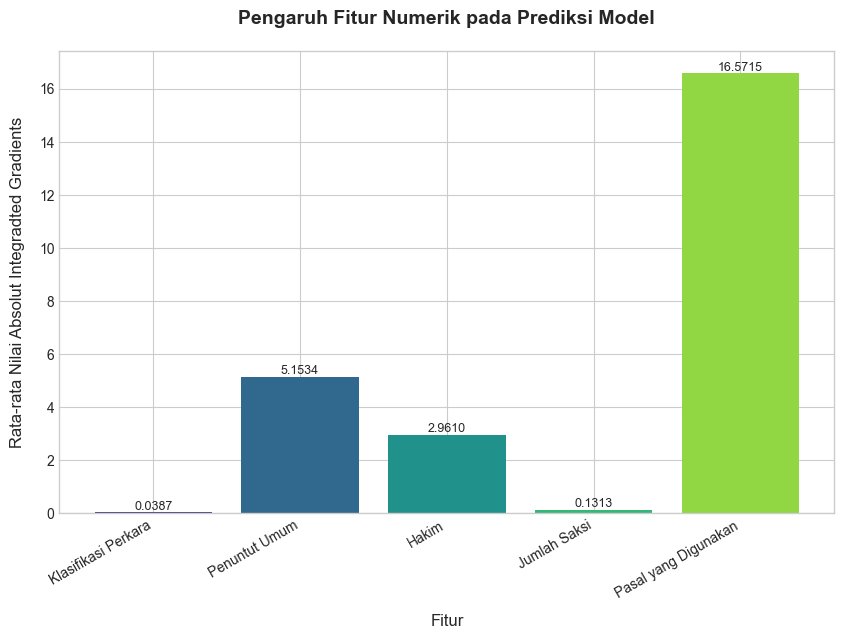

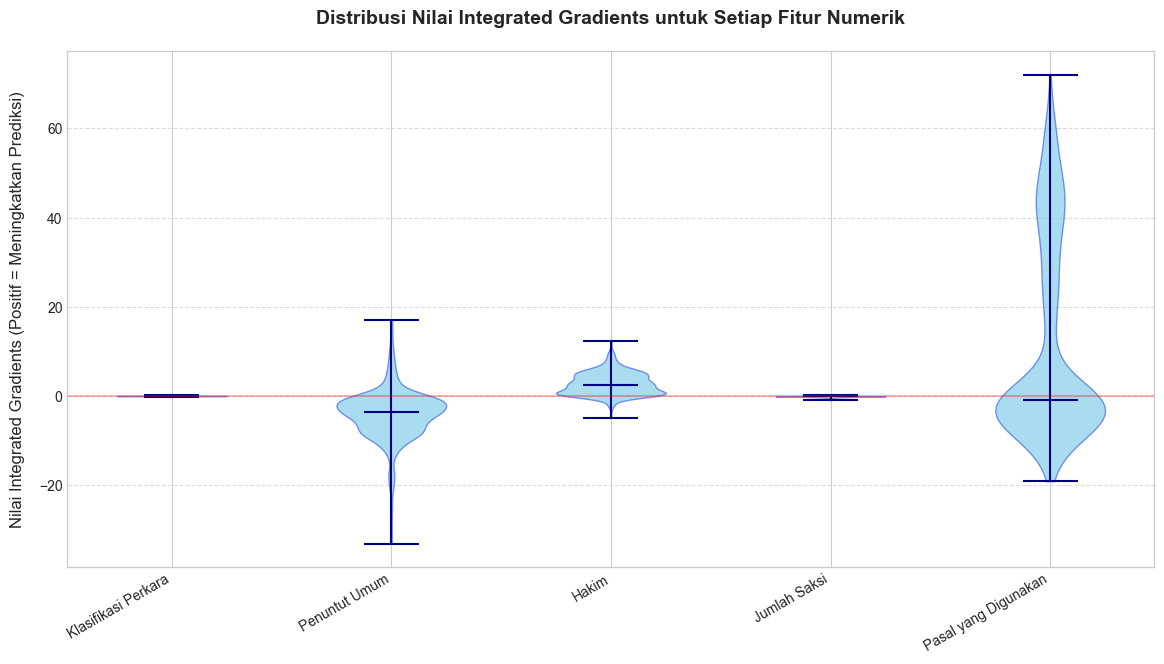

In [33]:

# ig_array_numeric = np.array(ig_numeric)
# mean_ig_numeric = np.mean(ig_array_numeric, axis=0)
# mean_ig_numeric = np.squeeze(mean_ig_numeric)
# mean_ig_numeric = mean_ig_numeric.astype(float)

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(mean_ig_numeric)), mean_ig_numeric)
# plt.xticks(range(len(mean_ig_numeric)), ['Klasifikasi Perkara', 'Penuntut Umum', 'Hakim', 'Jumlah Saksi', 'Pasal yang Digunakan'])
# plt.ylabel('Mean IG Attribution')
# plt.title('Mean Integrated Gradients per Feature')
# plt.grid(True)

# plt.show()

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Konfigurasi font 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Fitur numerik
# Proses Data Numerik
ig_array_numeric = np.array(ig_numeric)
mean_ig_numeric = np.mean(np.abs(ig_array_numeric), axis=0)
mean_ig_numeric = np.squeeze(mean_ig_numeric)
mean_ig_numeric = mean_ig_numeric.astype(float)

# Nama fitur numerik
feature_names_num = ['Klasifikasi Perkara', 'Penuntut Umum', 'Hakim', 'Jumlah Saksi', 'Pasal yang Digunakan']

# warna gradien
colors = sns.color_palette("viridis", len(feature_names_num))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(mean_ig_numeric)), mean_ig_numeric, color=colors)

# nilai di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xticks(range(len(mean_ig_numeric)))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Pengaruh Fitur Numerik pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Fitur', labelpad=10)
ax.set_ylabel('Rata-rata Nilai Absolut Integradted Gradients', labelpad=10)

# # anotasi dan grid
# ax.annotate('Fitur dengan nilai IG lebih tinggi memiliki pengaruh lebih besar pada prediksi model', 
#             xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=10, fontstyle='italic')
# ax.grid(axis='y', linestyle='--', alpha=0.7)
# fig.tight_layout(pad=2)
plt.show()

# plot violin
ig_array_violin = np.squeeze(ig_array_numeric)

fig, ax = plt.subplots(figsize=(12, 7))
data_to_plot = []
for i in range(ig_array_violin.shape[1]):
    data_to_plot.append(ig_array_violin[:, i])

violin_parts = ax.violinplot(data_to_plot, showmedians=True)

# Kustomisasi violin plot
for pc in violin_parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('royalblue')
    pc.set_alpha(0.7)

for partname in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    vp = violin_parts[partname]
    vp.set_edgecolor('navy')
    vp.set_linewidth(1.5)

ax.set_xticks(range(1, len(feature_names_num) + 1))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Distribusi Nilai Integrated Gradients untuk Setiap Fitur Numerik', fontweight='bold', pad=20)
ax.set_ylabel('Nilai Integrated Gradients (Positif = Meningkatkan Prediksi)', labelpad=10)
ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout(pad=2)
plt.show()